
--- Menú Principal del Bot de Scalping ---
1. Ejecutar bot en tiempo real
2. Realizar backtesting y ver gráfica
3. Descargar datos históricos en CSV
4. Salir
Elige una opción (1-4): 3
Descargando datos históricos...
Simulación: Obteniendo 10000 velas de BTC-USD en 1h...
Datos guardados en BTC-USD_1h_data.csv

--- Menú Principal del Bot de Scalping ---
1. Ejecutar bot en tiempo real
2. Realizar backtesting y ver gráfica
3. Descargar datos históricos en CSV
4. Salir
Elige una opción (1-4): 2
Iniciando backtesting con datos históricos...
Simulación: Obteniendo 5000 velas de BTC-USD en 1h...
[2025-09-06 08:17:59.335279] Comprando en: 10011.51
[2025-09-06 20:22:59.335279] Cerrando posición por Take Profit. Ganancia/Pérdida: 31.22
[2025-09-06 21:14:59.335279] Comprando en: 10053.78
[2025-09-07 05:47:59.335279] Cerrando posición por Take Profit. Ganancia/Pérdida: 30.40
[2025-09-07 06:55:59.335279] Comprando en: 10093.57
[2025-09-09 01:34:59.335279] Cerrando posición por Stop Loss. Ganancia/P

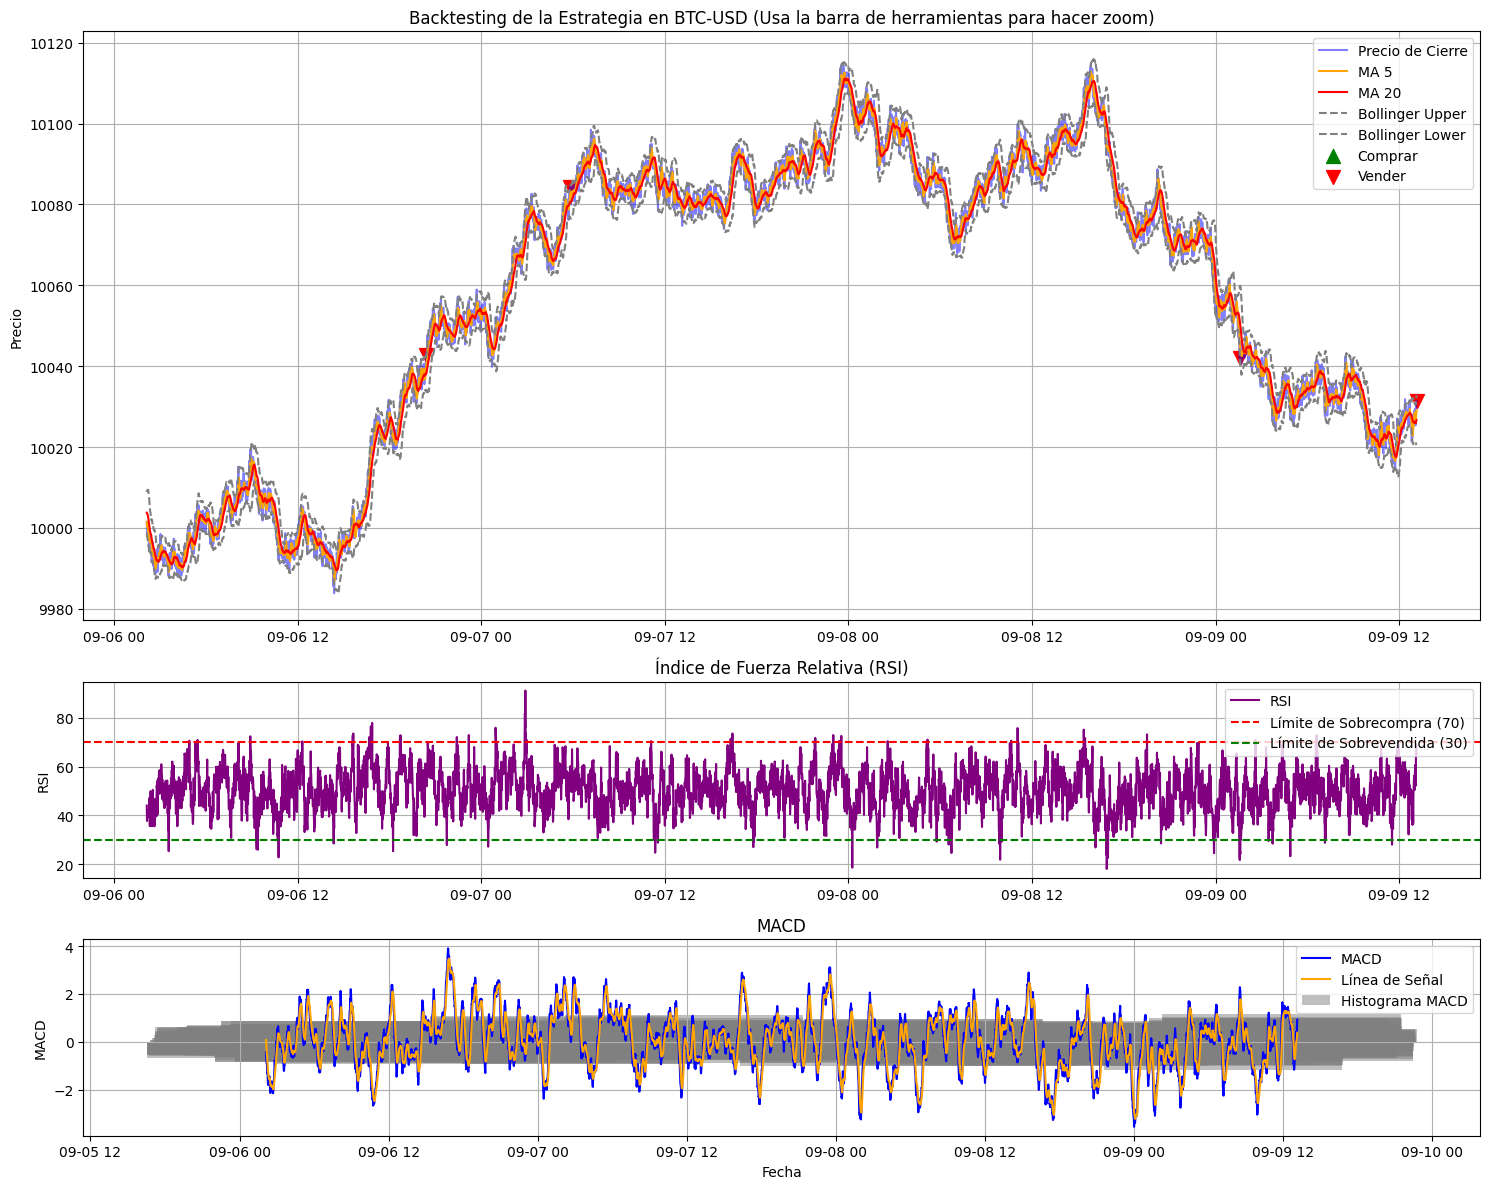


--- Menú Principal del Bot de Scalping ---
1. Ejecutar bot en tiempo real
2. Realizar backtesting y ver gráfica
3. Descargar datos históricos en CSV
4. Salir
Bot de trading detenido por el usuario.


In [7]:
#
# Scalping Trading Bot en Python
#
# Este script implementa una estrategia de scalping avanzada con múltiples indicadores técnicos
# (Medias Móviles, RSI, MACD, Bandas de Bollinger) y backtesting detallado.
#
# **ADVERTENCIA:** Este código es un ejemplo educativo y no debe ser utilizado para
# trading con dinero real sin una validación y testing exhaustivos.
# El trading en los mercados financieros conlleva un alto riesgo de pérdida.

import pandas as pd
import numpy as np
import time
from datetime import datetime
import ccxt
import yfinance as yf
import matplotlib.pyplot as plt

# --- Configuración Global del Bot ---
SIMULATION_MODE = True
TICKER = "BTC-USD"
TIMEFRAME = "1h"
DATA_SOURCE = "yfinance" # Opciones: "yfinance" o "ccxt"
LIMIT_DATA = 5000 # Cantidad de velas históricas para backtesting
# Claves de API para CCXT (si usas esta opción)
API_KEY = "TU_API_KEY_AQUI"
SECRET = "TU_SECRET_AQUI"

# --- Parámetros de la Estrategia (Ajustables) ---
SHORT_MA_PERIOD = 5
LONG_MA_PERIOD = 20
RSI_PERIOD = 14
MACD_FAST_PERIOD = 12
MACD_SLOW_PERIOD = 26
MACD_SIGNAL_PERIOD = 9
BOLLINGER_PERIOD = 20
BOLLINGER_DEV = 2

# Parámetros de gestión de riesgo
STOP_LOSS_PERCENT = 0.005  # 0.5%
TAKE_PROFIT_PERCENT = 0.003 # 0.3%

# --- Funciones de Datos ---
def get_historical_data(ticker, timeframe, limit=100, source=DATA_SOURCE):
    """
    Obtiene datos de precios históricos del proveedor de datos seleccionado.
    """
    if SIMULATION_MODE:
        print(f"Simulación: Obteniendo {limit} velas de {ticker} en {timeframe}...")
        np.random.seed(42)
        data = np.random.randn(limit).cumsum() + 10000
        dates = pd.date_range(end=datetime.now(), periods=limit, freq='min')
        df = pd.DataFrame({
            'timestamp': dates,
            'open': data,
            'high': data + np.random.rand(limit) * 10,
            'low': data - np.random.rand(limit) * 10,
            'close': data + np.random.rand(limit) * 5,
            'volume': np.random.rand(limit) * 100
        })
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df

    elif source == "yfinance":
        print(f"Real: Obteniendo datos de Yahoo Finance para {ticker}...")
        try:
            df = yf.download(tickers=ticker, period="1d", interval=timeframe)
            df = df.tail(limit)
            df.columns = [col.lower() for col in df.columns]
            df.rename(columns={'adj close': 'close'}, inplace=True)
            df.reset_index(inplace=True)
            df.rename(columns={'date': 'timestamp'}, inplace=True)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            return df
        except Exception as e:
            print(f"Error al obtener datos de Yahoo Finance: {e}")
            return None

    elif source == "ccxt":
        print(f"Real: Obteniendo datos de ccxt para {ticker}...")
        exchange = ccxt.binance({
            'apiKey': API_KEY,
            'secret': SECRET,
        })
        try:
            ohlcv = exchange.fetch_ohlcv(ticker, timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            return df
        except Exception as e:
            print(f"Error al obtener datos reales con ccxt: {e}")
            return None
    else:
        print("Fuente de datos no válida. Usa 'yfinance' o 'ccxt'.")
        return None

# --- Clases y Funciones de Indicadores Técnicos ---
class BacktestEngine:
    """
    Clase para realizar un backtesting detallado de una estrategia.
    """
    def __init__(self, data, strategy):
        self.data = data
        self.strategy = strategy
        self.initial_cash = 10000.0
        self.cash = self.initial_cash
        self.shares = 0.0
        self.trades = []
        self.portfolio_value = []
        self.in_position = False
        self.entry_price = 0

    def run(self):
        """Ejecuta el backtesting."""
        for i in range(len(self.data)):
            current_data = self.data.iloc[:i+1]
            current_price = current_data['close'].iloc[-1]

            if self.in_position:
                status = self.check_position_status(current_price)
                if status != "continue":
                    self.close_position(current_price, current_data['timestamp'].iloc[-1], status)

            if not self.in_position:
                signal = self.strategy.get_signal(current_data)
                if signal == "buy":
                    self.open_position(current_price, current_data['timestamp'].iloc[-1])

            self.portfolio_value.append(self.cash + self.shares * current_price)

        # Cerrar cualquier posición pendiente al final
        if self.in_position:
            self.close_position(self.data['close'].iloc[-1], self.data['timestamp'].iloc[-1], "End of Backtest")

    def open_position(self, price, timestamp):
        """Abre una posición de compra."""
        self.in_position = True
        self.entry_price = price
        self.shares = self.cash / price
        self.cash = 0
        self.trades.append({
            'entry_timestamp': timestamp,
            'entry_price': price,
            'exit_timestamp': None,
            'exit_price': None,
            'profit_loss': None,
            'reason': 'Buy Signal'
        })
        print(f"[{timestamp}] Comprando en: {price:.2f}")

    def close_position(self, price, timestamp, reason):
        """Cierra la posición abierta."""
        if not self.trades: return
        trade = self.trades[-1]
        profit_loss = (price - trade['entry_price']) * self.shares
        self.cash += self.shares * price
        self.shares = 0
        self.in_position = False

        trade['exit_timestamp'] = timestamp
        trade['exit_price'] = price
        trade['profit_loss'] = profit_loss
        trade['reason'] = reason
        print(f"[{timestamp}] Cerrando posición por {reason}. Ganancia/Pérdida: {profit_loss:.2f}")

    def check_position_status(self, current_price):
        """Verifica si se ha alcanzado el Stop-Loss o Take-Profit."""
        profit_loss_pct = (current_price - self.entry_price) / self.entry_price

        if profit_loss_pct >= TAKE_PROFIT_PERCENT:
            return "Take Profit"
        elif profit_loss_pct <= -STOP_LOSS_PERCENT:
            return "Stop Loss"
        else:
            return "continue"

    def get_results(self):
        """Calcula y devuelve las métricas de rendimiento."""
        final_value = self.portfolio_value[-1] if self.portfolio_value else self.initial_cash
        total_return = (final_value - self.initial_cash) / self.initial_cash

        drawdown = 0
        peak = self.initial_cash
        for value in self.portfolio_value:
            if value > peak:
                peak = value
            drawdown = max(drawdown, (peak - value) / peak)

        winning_trades = [t for t in self.trades if t['profit_loss'] is not None and t['profit_loss'] > 0]
        losing_trades = [t for t in self.trades if t['profit_loss'] is not None and t['profit_loss'] < 0]

        return {
            'total_return': total_return,
            'final_value': final_value,
            'num_trades': len(self.trades),
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': len(winning_trades) / len(self.trades) if self.trades else 0,
            'max_drawdown': drawdown,
            'trades': self.trades,
            'portfolio_value': self.portfolio_value
        }

class Strategy:
    """Clase base para la estrategia de trading."""
    def __init__(self, data):
        self.data = data

    def calculate_indicators(self):
        """Calcula todos los indicadores necesarios."""
        self.data['ma_short'] = self.data['close'].rolling(window=SHORT_MA_PERIOD).mean()
        self.data['ma_long'] = self.data['close'].rolling(window=LONG_MA_PERIOD).mean()

        delta = self.data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=RSI_PERIOD).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_PERIOD).mean()
        rs = gain / loss
        self.data['rsi'] = 100 - (100 / (1 + rs))

        exp1 = self.data['close'].ewm(span=MACD_FAST_PERIOD, adjust=False).mean()
        exp2 = self.data['close'].ewm(span=MACD_SLOW_PERIOD, adjust=False).mean()
        self.data['macd'] = exp1 - exp2
        self.data['signal_line'] = self.data['macd'].ewm(span=MACD_SIGNAL_PERIOD, adjust=False).mean()
        self.data['macd_histogram'] = self.data['macd'] - self.data['signal_line']

        self.data['bollinger_mid'] = self.data['close'].rolling(window=BOLLINGER_PERIOD).mean()
        self.data['bollinger_std'] = self.data['close'].rolling(window=BOLLINGER_PERIOD).std()
        self.data['bollinger_upper'] = self.data['bollinger_mid'] + (self.data['bollinger_std'] * BOLLINGER_DEV)
        self.data['bollinger_lower'] = self.data['bollinger_mid'] - (self.data['bollinger_std'] * BOLLINGER_DEV)

        self.data.dropna(inplace=True)

    def get_signal(self, current_data):
        """
        Genera una señal de compra o venta basada en múltiples indicadores.
        """
        if len(current_data) < LONG_MA_PERIOD + 1 or current_data.iloc[-1].isnull().any():
            return "hold"

        # Criterios para la señal de compra
        ma_cross_up = current_data['ma_short'].iloc[-1] > current_data['ma_long'].iloc[-1] and \
                      current_data['ma_short'].iloc[-2] <= current_data['ma_long'].iloc[-2]
        rsi_ok = current_data['rsi'].iloc[-1] < 70
        macd_cross_up = current_data['macd'].iloc[-1] > current_data['signal_line'].iloc[-1] and \
                        current_data['macd'].iloc[-2] <= current_data['signal_line'].iloc[-2]

        if ma_cross_up and rsi_ok and macd_cross_up:
            return "buy"

        return "hold"

# --- Lógica Principal y Menú ---
def run_realtime_bot():
    """
    Lógica principal del bot para operar en tiempo real.
    """
    print("Iniciando el bot de trading en tiempo real...")
    df = get_historical_data(TICKER, TIMEFRAME, limit=100, source=DATA_SOURCE)
    if df is None:
        print("No se pudieron obtener los datos. Terminando.")
        return

    strategy = Strategy(df)
    strategy.calculate_indicators()

    position_open = False
    entry_price = None

    while True:
        df = get_historical_data(TICKER, TIMEFRAME, limit=100, source=DATA_SOURCE)
        if df is None:
            time.sleep(60)
            continue

        strategy.data = df
        strategy.calculate_indicators()
        current_price = df['close'].iloc[-1]

        if position_open:
            if (current_price - entry_price) / entry_price >= TAKE_PROFIT_PERCENT:
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Posición cerrada por TAKE PROFIT.")
                close_position(TICKER, 0.01, "Take Profit")
                position_open = False
                entry_price = None
            elif (current_price - entry_price) / entry_price <= -STOP_LOSS_PERCENT:
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Posición cerrada por STOP LOSS.")
                close_position(TICKER, 0.01, "Stop Loss")
                position_open = False
                entry_price = None
            else:
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Posición abierta. Precio actual: {current_price:.2f}")

        if not position_open:
            signal = strategy.get_signal(df)

            if signal == "buy":
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Señal de COMPRA detectada.")
                place_order("buy", TICKER, 0.01)
                position_open = True
                entry_price = current_price
            else:
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Esperando una señal... Precio actual: {current_price:.2f}")

        time.sleep(60)

def perform_backtest():
    """
    Realiza un backtesting de la estrategia con datos históricos y grafica el resultado.
    """
    print("Iniciando backtesting con datos históricos...")
    df = get_historical_data(TICKER, TIMEFRAME, limit=LIMIT_DATA, source=DATA_SOURCE)
    if df is None:
        return

    strategy = Strategy(df)
    strategy.calculate_indicators()

    engine = BacktestEngine(strategy.data, strategy)
    engine.run()
    results = engine.get_results()

    print("\n--- Resultados del Backtesting ---")
    print(f"Valor inicial de la cartera: {engine.initial_cash:.2f}")
    print(f"Valor final de la cartera: {results['final_value']:.2f}")
    print(f"Retorno total: {results['total_return'] * 100:.2f}%")
    print(f"Número total de operaciones: {results['num_trades']}")
    print(f"Operaciones ganadoras: {results['winning_trades']}")
    print(f"Operaciones perdedoras: {results['losing_trades']}")
    print(f"Tasa de victorias: {results['win_rate'] * 100:.2f}%")
    print(f"Max Drawdown: {results['max_drawdown'] * 100:.2f}%")

    # Graficar resultados
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [3, 1, 1]})

    # Gráfico de precios con Medias Móviles y Bandas de Bollinger
    ax1.plot(strategy.data['timestamp'], strategy.data['close'], label='Precio de Cierre', color='blue', alpha=0.5)
    ax1.plot(strategy.data['timestamp'], strategy.data['ma_short'], label=f'MA {SHORT_MA_PERIOD}', color='orange')
    ax1.plot(strategy.data['timestamp'], strategy.data['ma_long'], label=f'MA {LONG_MA_PERIOD}', color='red')
    ax1.plot(strategy.data['timestamp'], strategy.data['bollinger_upper'], label='Bollinger Upper', color='gray', linestyle='--')
    ax1.plot(strategy.data['timestamp'], strategy.data['bollinger_lower'], label='Bollinger Lower', color='gray', linestyle='--')

    # Añadir los puntos de compra y venta
    buy_trades = [t for t in results['trades'] if t['reason'] == 'Buy Signal']
    sell_trades = [t for t in results['trades'] if t['exit_price'] is not None]

    buy_timestamps = [t['entry_timestamp'] for t in buy_trades]
    buy_prices = [t['entry_price'] for t in buy_trades]
    ax1.scatter(buy_timestamps, buy_prices, marker='^', color='green', s=100, label='Comprar')

    sell_timestamps = [t['exit_timestamp'] for t in sell_trades]
    sell_prices = [t['exit_price'] for t in sell_trades]
    ax1.scatter(sell_timestamps, sell_prices, marker='v', color='red', s=100, label='Vender')

    ax1.set_title(f'Backtesting de la Estrategia en {TICKER} (Usa la barra de herramientas para hacer zoom)')
    ax1.set_ylabel('Precio')
    ax1.legend()
    ax1.grid(True)

    # Gráfico del RSI
    ax2.plot(strategy.data['timestamp'], strategy.data['rsi'], label='RSI', color='purple')
    ax2.axhline(70, linestyle='--', color='red', label='Límite de Sobrecompra (70)')
    ax2.axhline(30, linestyle='--', color='green', label='Límite de Sobrevendida (30)')
    ax2.set_title('Índice de Fuerza Relativa (RSI)')
    ax2.set_ylabel('RSI')
    ax2.legend()
    ax2.grid(True)

    # Gráfico del MACD
    ax3.plot(strategy.data['timestamp'], strategy.data['macd'], label='MACD', color='blue')
    ax3.plot(strategy.data['timestamp'], strategy.data['signal_line'], label='Línea de Señal', color='orange')
    ax3.bar(strategy.data['timestamp'], strategy.data['macd_histogram'], label='Histograma MACD', color='gray', alpha=0.5)
    ax3.set_title('MACD')
    ax3.set_xlabel('Fecha')
    ax3.set_ylabel('MACD')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

def place_order(order_type, ticker, amount):
    """Simula la colocación de una orden en el mercado."""
    print(f"Simulación: Colocando orden de {order_type.upper()} para {amount} de {ticker}.")

def close_position(ticker, amount, reason):
    """Simula el cierre de una posición abierta."""
    print(f"Simulación: Cerrando posición de {amount} de {ticker} por {reason}.")

def download_data_as_csv():
    """Descarga los datos históricos en un archivo CSV."""
    print("Descargando datos históricos...")
    df = get_historical_data(TICKER, TIMEFRAME, limit=10000, source=DATA_SOURCE)
    if df is None:
        print("No se pudieron obtener los datos para descargar.")
        return
    file_name = f"{TICKER.replace('/', '_')}_{TIMEFRAME}_data.csv"
    df.to_csv(file_name, index=False)
    print(f"Datos guardados en {file_name}")

def main_loop():
    """Bucle principal del bot de trading que muestra un menú al usuario."""
    while True:
        print("\n--- Menú Principal del Bot de Scalping ---")
        print("1. Ejecutar bot en tiempo real")
        print("2. Realizar backtesting y ver gráfica")
        print("3. Descargar datos históricos en CSV")
        print("4. Salir")

        choice = input("Elige una opción (1-4): ")

        if choice == '1':
            run_realtime_bot()
        elif choice == '2':
            perform_backtest()
        elif choice == '3':
            download_data_as_csv()
        elif choice == '4':
            print("Saliendo del bot. ¡Hasta pronto!")
            break
        else:
            print("Opción no válida. Por favor, elige un número del 1 al 4.")

if __name__ == "__main__":
    try:
        main_loop()
    except KeyboardInterrupt:
        print("Bot de trading detenido por el usuario.")
    except Exception as e:
        print(f"Ha ocurrido un error inesperado: {e}")
